In [23]:
%load_ext autoreload
import os
import sys

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
os.environ['TRANSFORMERS_CACHE'] = '/mnt/swordfish-pool2/milad/hf-cache-new'
os.environ['HF_DATASETS_CACHE'] = '/mnt/swordfish-pool2/milad/hf-cache-new'
os.environ["OPENAI_API_KEY"]= 'xxx'
os.environ['CUDA_VISIBLE_DEVICES'] = '6'
os.environ['CUDA_LAUNCH_BLOCKING'] = '0'
sys.path.append('./src-py')

In [25]:
import json
import os
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
import re
from collections import Counter

pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)


%autoreload
import utils
import prompts
import random

from tabulate import tabulate
import tiktoken
from llm_based_evaluation import *

In [26]:
from transformers import AutoTokenizer, pipeline

In [27]:
import json
keys = json.load(open('./keys.json'))
for key, val in keys.items():
    os.environ[key] = val

In [28]:
from huggingface_hub import login

login(os.environ['hf_token'])

In [29]:
output_dir = '/mnt/swordfish-pool2/milad/communicating-science-to-the-public/'
models_folder = "/mnt/swordfish-pool2/milad/communicating-science-to-the-public/models/"

In [30]:
gpt_tokenizer = tiktoken.encoding_for_model("gpt-3.5-turbo")
llama_tokenizer = AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3-8B")

In [21]:
ds_path = '/mnt/swordfish-pool2/milad/communicating-science-to-the-public/eval_experiment_500'

### Evaluate Science Models

- Now we will evalaute the following models on a sample from the test set using only the generic prompt
    - LLAMA-3 baseline
    - Qwen baseline
    - LLAMA-3 fine-tuned on DeepSeek generated conversations
    - Qwen  fine-tuned on DeepSeek generated conversations

### Evaluation

#### Basic Evaluation

In [88]:
generated_convs = {
    #'llama3-baseline':datasets.load_from_disk(ds_path + '/baseline-advanced-prompt-llama3-test-conv-ds/'),
    'qwen-baseline':datasets.load_from_disk(ds_path + '/baseline_qwen_gen_conv'),
    'ft-qwen-on-deepseek' :datasets.load_from_disk(ds_path + '/ft_qwen_gen_conv'),
    'llama-baseline':datasets.load_from_disk(ds_path + '/baseline_llama3_gen_conv'),
    'ft-llama-on-deepseek' :datasets.load_from_disk(ds_path + '/ft_llama3_gen_conv'),
}

In [37]:
# generated_convs['qwen-baseline'] = generated_convs['qwen-baseline'].map(lambda row: {'pr-article': paper_id_to_article[row['paper_id']]})
# generated_convs['ft-qwen-on-deepseek'] = generated_convs['ft-qwen-on-deepseek'].map(lambda row: {'pr-article': paper_id_to_article[row['paper_id']]})

In [89]:
def evalaute_convs(datasets):
    eval_results = {}
    for name, ds in datasets.items():
        eval_results[name] = utils.evaluate_conv(ds['conversation'], None, ds['pr-article'])

    print(tabulate(
        [[name] + list(eval_res.values())[:3] for name, eval_res in eval_results.items()],
        headers=['Prompt', 'Rouge-1', 'Rouge-L', 'BERT-f1']
    ))

In [91]:
print('Results on 500 sample')
all_synth_conversations = evalaute_convs(generated_convs)

Results on 500 sample
Prompt                  Rouge-1    Rouge-L    BERT-f1
--------------------  ---------  ---------  ---------
qwen-baseline             0.3        0.127      0.825
ft-qwen-on-deepseek       0.345      0.135      0.827
llama-baseline            0.333      0.144      0.821
ft-llama-on-deepseek      0.43       0.168      0.834


In [53]:
all_synth_conversations = evalaute_convs(generated_convs)

Prompt                  Rouge-1    Rouge-L    BERT-f1
--------------------  ---------  ---------  ---------
qwen-baseline             0.304      0.128      0.822
ft-qwen-on-deepseek       0.353      0.136      0.824
llama-baseline            0.346      0.147      0.819
ft-llama-on-deepseek      0.435      0.167      0.832


#### LLM-based Evaluation

#### Using Mixtral:

In [11]:
generated_convs = {
    'qwen-baseline':[datasets.load_from_disk(ds_path + '/baseline_qwen_gen_conv/'), ds_path + '/baseline_qwen_gen_conv'],
    'ft-qwen-on-deepseek' :[datasets.load_from_disk(ds_path + '/ft_qwen_gen_conv/'),ds_path +  '/ft_qwen_gen_conv/'],
    'llama-baseline':[datasets.load_from_disk(ds_path + '/baseline_llama3_gen_conv/'), ds_path + '/baseline_llama3_gen_conv'],
    'ft-llama-on-deepseek' :[datasets.load_from_disk(ds_path + '/ft_llama3_gen_conv/'),ds_path +  '/ft_llama3_gen_conv/'],
}

In [31]:
prompts_to_eval = [prompts.clarity_eval_prompt, prompts.scientific_context_eval_prompt, prompts.societal_context_eval_prompt]

llm_eval_results = llm_based_evaluation(prompts_to_eval, generated_convs, evaluator_name="mistralai/Mixtral-8x7B-v0.1", force_generation=False)

  0%|                                                                                         | 0/500 [00:01<?, ?it/s]


APIConnectionError: Connection error.

#### Using GPT-4

In [13]:
generated_convs = {
    'qwen-baseline':[datasets.load_from_disk(ds_path + '/baseline_qwen_gen_conv/'), ds_path + '/baseline_qwen_gen_conv'],
    'ft-qwen-on-deepseek' :[datasets.load_from_disk(ds_path + '/ft_qwen_gen_conv/'),  ds_path +  '/ft_qwen_gen_conv/'],
    'llama-baseline':[datasets.load_from_disk(ds_path + '/baseline_llama3_gen_conv/'), ds_path + '/baseline_llama3_gen_conv'],
    'ft-llama-on-deepseek' :[datasets.load_from_disk(ds_path + '/ft_llama3_gen_conv/'), ds_path +  '/ft_llama3_gen_conv/'],
}

In [118]:
prompts_to_eval = [prompts.clarity_eval_prompt, prompts.scientific_context_eval_prompt, prompts.societal_context_eval_prompt]

llm_eval_results = llm_based_evaluation(prompts_to_eval, generated_convs, evaluator_name="gpt-4.1-2025-04-14", force_generation=False)

Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/eval_experiment_500//baseline_qwen_gen_conv/ds_eval/gpt-4.1-2025-04-14 from already saved file
Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/eval_experiment_500//ft_qwen_gen_conv//ds_eval/gpt-4.1-2025-04-14 from already saved file
Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/eval_experiment_500//baseline_llama3_gen_conv/ds_eval/gpt-4.1-2025-04-14 from already saved file
Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/eval_experiment_500//ft_llama3_gen_conv//ds_eval/gpt-4.1-2025-04-14 from already saved file
#                       clarity_eval_prompt    scientific_eval_prompt    societal_eval_prompt    Avg
--------------------  ---------------------  ------------------------  ----------------------  -----
qwen-baseline                          4.85                      2                       2.72   3.19
ft-qwen-on-deepseek                    

#### Using DeepSeek

In [46]:
generated_convs = {
    'qwen-baseline':[datasets.load_from_disk(ds_path + '/baseline_qwen_gen_conv/'), ds_path + '/baseline_qwen_gen_conv'],
    'ft-qwen-on-deepseek' :[datasets.load_from_disk(ds_path + '/ft_qwen_gen_conv/'),ds_path +  '/ft_qwen_gen_conv/'],
    'llama-baseline':[datasets.load_from_disk(ds_path + '/baseline_llama3_gen_conv/'), ds_path + '/baseline_llama3_gen_conv'],
    'ft-llama-on-deepseek' :[datasets.load_from_disk(ds_path + '/ft_llama3_gen_conv/'),ds_path +  '/ft_llama3_gen_conv/'],
}

In [51]:
prompts_to_eval = [prompts.clarity_eval_prompt, prompts.scientific_context_eval_prompt, prompts.societal_context_eval_prompt]

llm_eval_results = llm_based_evaluation(prompts_to_eval, generated_convs, force_generation=False, evaluator_name="deepseek-ai/DeepSeek-R1-Distill-Qwen-14B")

Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/eval_experiment_500//baseline_qwen_gen_conv/ds_eval/deepseek-ai from already saved file
Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/eval_experiment_500//ft_qwen_gen_conv//ds_eval/deepseek-ai from already saved file
Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/eval_experiment_500//baseline_llama3_gen_conv/ds_eval/deepseek-ai from already saved file
Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/eval_experiment_500//ft_llama3_gen_conv//ds_eval/deepseek-ai from already saved file
#                       clarity_eval_prompt    scientific_eval_prompt    societal_eval_prompt    Avg
--------------------  ---------------------  ------------------------  ----------------------  -----
qwen-baseline                          4.04                      2.32                    1.82   2.73
ft-qwen-on-deepseek                    3.93                      2.

In [20]:
# generated_convs['ft-llama3-on-deepseek'][0] = generated_convs['ft-llama3-on-deepseek'][0].map(lambda row: {'conversation': '\n\n'.join(['{}: {}'.format('Journalist', x['content']) if x['role'] == 'assistant' else '{}: {}'.format('Researcher', x['content']) for x in row['generated_conversation'][1:]])})
# generated_convs['llama3-baseline'][0] = generated_convs['llama3-baseline'][0].map(lambda row: {'conversation': '\n\n'.join(['{}: {}'.format('Journalist', x['content']) if x['role'] == 'assistant' else '{}: {}'.format('Researcher', x['content']) for x in row['generated_conversation'][1:]])})
# generated_convs['gpt3-baseline'][0] = generated_convs['gpt3-baseline'][0].remove_columns(['societal_eval_prompt_scoring_parsed', 'scientific_eval_prompt_scoring_parsed', 'clarity_eval_prompt_scoring_parsed'])
# generated_convs['llama3-baseline'][0] = generated_convs['llama3-baseline'][0].remove_columns(['societal_eval_prompt_scoring_parsed', 'scientific_eval_prompt_scoring_parsed', 'clarity_eval_prompt_scoring_parsed'])
# generated_convs['ft-llama3-on-deepseek'][0] = generated_convs['ft-llama3-on-deepseek'][0].remove_columns(['societal_eval_prompt_scoring_parsed', 'scientific_eval_prompt_scoring_parsed', 'clarity_eval_prompt_scoring_parsed'])

-------

#### Evaluating the ground-truth generated convs:

In [13]:
gt_convs = {'original_deepseek_conv': [datasets.load_from_disk('/mnt/swordfish-pool2/milad/communicating-science-to-the-public/processed_test_ds_sample'), '/mnt/swordfish-pool2/milad/communicating-science-to-the-public/processed_test_ds_sample']}

In [14]:
prompts_to_eval = [prompts.clarity_eval_prompt, prompts.scientific_context_eval_prompt, prompts.societal_context_eval_prompt]

llm_eval_gt_results = llm_based_evaluation(prompts_to_eval, gt_convs, force_generation=False)

Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/processed_test_ds_sample from already saved file
#                         clarity_eval_prompt    scientific_eval_prompt    societal_eval_prompt    Avg
----------------------  ---------------------  ------------------------  ----------------------  -----
original_deepseek_conv                   4.52                       2.2                    2.06   2.93


------

### Analysis of the automatic evalaution

In [15]:
# To add the topic to the data
deepseek_conv_dataset = datasets.load_from_disk('/mnt/swordfish-pool2/milad/communicating-science-to-the-public/deepseek-final-conv-ds-cleaned/')
paper_id_to_article = {x['id']: x['pr-article'] for x in deepseek_conv_dataset}
paper_id_to_topic = {x['id']: x['Topic'] for x in deepseek_conv_dataset}

In [17]:
generated_convs = {
    'qwen-baseline':[datasets.load_from_disk(ds_path + '/baseline_qwen_gen_conv/'), ds_path + '/baseline_qwen_gen_conv'],
    'ft-qwen-on-deepseek' :[datasets.load_from_disk(ds_path + '/ft_qwen_gen_conv/'),  ds_path +  '/ft_qwen_gen_conv/'],
    'llama-baseline':[datasets.load_from_disk(ds_path + '/baseline_llama3_gen_conv/'), ds_path + '/baseline_llama3_gen_conv'],
    'ft-llama-on-deepseek' :[datasets.load_from_disk(ds_path + '/ft_llama3_gen_conv/'), ds_path +  '/ft_llama3_gen_conv/'],
}

In [18]:
# generated_convs['llama3-baseline-adv-prompt'][0] = generated_convs['llama3-baseline-adv-prompt'][0].map(lambda row: {'topic': paper_id_to_topic[row['paper_id']]})
# generated_convs['qwen-baseline-adv-prompt'][0] = generated_convs['qwen-baseline-adv-prompt'][0].map(lambda row: {'topic': paper_id_to_topic[row['paper_id']]})
# generated_convs['ft-llama3-on-deepseek'][0] = generated_convs['ft-llama3-on-deepseek'][0].map(lambda row: {'topic': paper_id_to_topic[row['paper_id']]})
# generated_convs['ft-qwen-on-deepseek'][0] = generated_convs['ft-qwen-on-deepseek'][0].map(lambda row: {'topic': paper_id_to_topic[row['paper_id']]})

In [117]:
prompts_to_eval = [prompts.clarity_eval_prompt, prompts.scientific_context_eval_prompt, prompts.societal_context_eval_prompt]

llm_eval_results = llm_based_evaluation(prompts_to_eval, generated_convs, force_generation=False, evaluator_name="deepseek-ai/DeepSeek-R1-Distill-Qwen-14B")

Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/eval_experiment_500//baseline_qwen_gen_conv/ds_eval/deepseek-ai from already saved file
Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/eval_experiment_500//ft_qwen_gen_conv//ds_eval/deepseek-ai from already saved file
Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/eval_experiment_500//baseline_llama3_gen_conv/ds_eval/deepseek-ai from already saved file
Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/eval_experiment_500//ft_llama3_gen_conv//ds_eval/deepseek-ai from already saved file
#                       clarity_eval_prompt    scientific_eval_prompt    societal_eval_prompt    Avg
--------------------  ---------------------  ------------------------  ----------------------  -----
qwen-baseline                          4.04                      2.32                    1.82   2.73
ft-qwen-on-deepseek                    3.93                      2.

In [53]:
import matplotlib.pyplot as plt
import numpy as np

def histogram_of_scores(llm_eval_scores, scoring_scheme, chart_title):
    llm_eval_scores = {x[0]: [s['score'] for s in x[1][scoring_scheme]] for x in llm_eval_results.items()}
    # Assuming llm_eval_scores is a dict {model_name: list of scores}
    bin_edges = np.histogram_bin_edges(np.concatenate(list(llm_eval_scores.values())), bins='auto')
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_width = (bin_edges[1] - bin_edges[0])
    num_models = len(llm_eval_scores)
    bar_width = bin_width / num_models
    
    for i, (key, val) in enumerate(llm_eval_scores.items()):
        counts, _ = np.histogram(val, bins=bin_edges)
        offset = (i - num_models / 2) * bar_width + bar_width / 2
        plt.bar(bin_centers + offset, counts, width=bar_width, alpha=0.8, label=key)
    
    plt.xlabel("Score")
    plt.ylabel("Count")
    plt.title(chart_title)
    plt.legend()
    plt.tight_layout()
    plt.show()

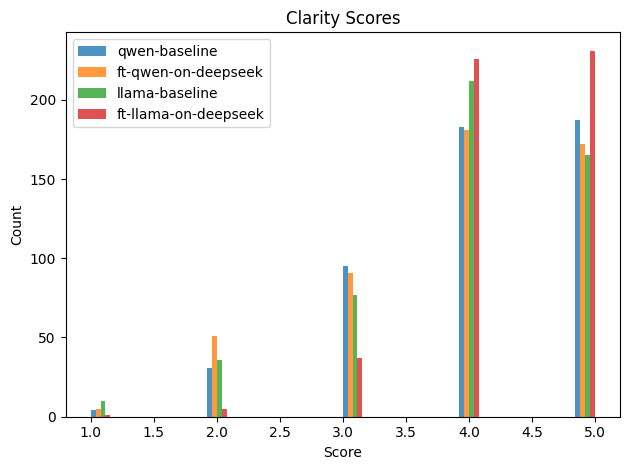

In [56]:
histogram_of_scores(llm_eval_results, 'clarity_eval_prompt_scoring_parsed', 'Clarity Scores')

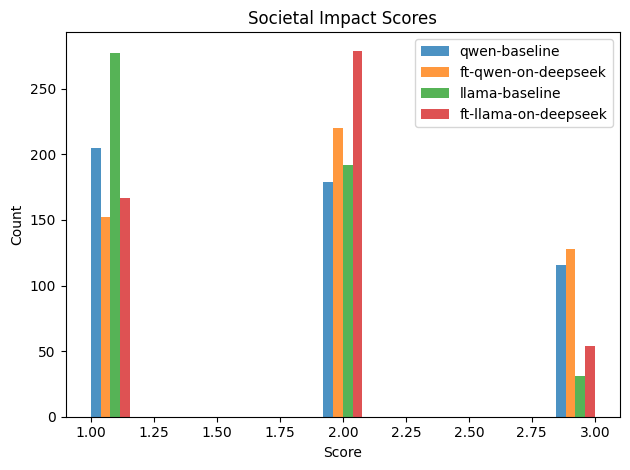

In [57]:
histogram_of_scores(llm_eval_results, 'societal_eval_prompt_scoring_parsed', 'Societal Impact Scores')

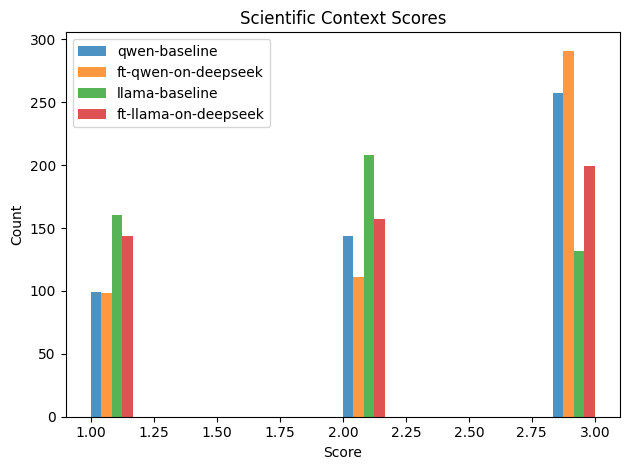

In [58]:
histogram_of_scores(llm_eval_results, 'scientific_eval_prompt_scoring_parsed', 'Scientific Context Scores')

### Per topic analysis

In [44]:
for topic in set(paper_id_to_topic.values()):
    topic_ds = llm_eval_results['qwen-baseline'].filter(lambda row: row['topic'] ==topic)
    print(topic, '#inst: ', len(topic_ds))
    print(tabulate(
        [[name] + get_llm_avg_scores(res.filter(lambda row: row['topic'] ==topic), prompts_to_eval) for name, res in llm_eval_results.items()],
        headers=['#'] + [p['strategy_name'] for p in prompts_to_eval] + ['Avg']
    ))
    print()
    print('===============')

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Nano #inst:  27


Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

#                       clarity_eval_prompt    scientific_eval_prompt    societal_eval_prompt    Avg
--------------------  ---------------------  ------------------------  ----------------------  -----
qwen-baseline                          4.74                      2.07                    2.7    3.17
ft-qwen-on-deepseek                    4.63                      2.26                    2.89   3.26
llama-baseline                         4.81                      1.48                    2.07   2.79
ft-llama-on-deepseek                   4.81                      2.07                    2.78   3.22



Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Physics #inst:  47


Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

#                       clarity_eval_prompt    scientific_eval_prompt    societal_eval_prompt    Avg
--------------------  ---------------------  ------------------------  ----------------------  -----
qwen-baseline                          4.79                      2.13                    2.26   3.06
ft-qwen-on-deepseek                    4.77                      2.38                    2.77   3.31
llama-baseline                         4.89                      2.02                    1.96   2.96
ft-llama-on-deepseek                   4.72                      2.34                    2.77   3.28



Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Computer #inst:  13


Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

#                       clarity_eval_prompt    scientific_eval_prompt    societal_eval_prompt    Avg
--------------------  ---------------------  ------------------------  ----------------------  -----
qwen-baseline                             5                      1.85                    2.46   3.1
ft-qwen-on-deepseek                       5                      2                       2.69   3.23
llama-baseline                            5                      1.46                    2.08   2.85
ft-llama-on-deepseek                      5                      2.31                    2.54   3.28



Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Other #inst:  18


Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

#                       clarity_eval_prompt    scientific_eval_prompt    societal_eval_prompt    Avg
--------------------  ---------------------  ------------------------  ----------------------  -----
qwen-baseline                          5                         2.11                    2.89   3.33
ft-qwen-on-deepseek                    4.72                      2.56                    2.89   3.39
llama-baseline                         4.94                      1.56                    2.56   3.02
ft-llama-on-deepseek                   5                         2                       2.89   3.3



Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Medicine #inst:  198


Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

#                       clarity_eval_prompt    scientific_eval_prompt    societal_eval_prompt    Avg
--------------------  ---------------------  ------------------------  ----------------------  -----
qwen-baseline                          4.82                      1.99                    2.88   3.23
ft-qwen-on-deepseek                    4.69                      2.25                    2.89   3.28
llama-baseline                         4.84                      1.8                     2.49   3.04
ft-llama-on-deepseek                   4.86                      1.85                    2.85   3.19



Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Biology #inst:  94


Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

#                       clarity_eval_prompt    scientific_eval_prompt    societal_eval_prompt    Avg
--------------------  ---------------------  ------------------------  ----------------------  -----
qwen-baseline                          4.87                      1.89                    2.79   3.18
ft-qwen-on-deepseek                    4.7                       2.19                    2.85   3.25
llama-baseline                         4.94                      1.79                    2.41   3.05
ft-llama-on-deepseek                   4.97                      1.97                    2.73   3.22



Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Chemistry #inst:  44


Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

#                       clarity_eval_prompt    scientific_eval_prompt    societal_eval_prompt    Avg
--------------------  ---------------------  ------------------------  ----------------------  -----
qwen-baseline                          4.86                      1.84                    2.39   3.03
ft-qwen-on-deepseek                    4.68                      2                       2.89   3.19
llama-baseline                         4.98                      1.73                    2      2.9
ft-llama-on-deepseek                   4.91                      1.98                    2.8    3.23



Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Space #inst:  9


Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

#                       clarity_eval_prompt    scientific_eval_prompt    societal_eval_prompt    Avg
--------------------  ---------------------  ------------------------  ----------------------  -----
qwen-baseline                          5                         2.22                    2.56   3.26
ft-qwen-on-deepseek                    4.67                      2.44                    3      3.37
llama-baseline                         4.78                      2.11                    2.56   3.15
ft-llama-on-deepseek                   5                         2.33                    3      3.44



Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Earth #inst:  50


Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

#                       clarity_eval_prompt    scientific_eval_prompt    societal_eval_prompt    Avg
--------------------  ---------------------  ------------------------  ----------------------  -----
qwen-baseline                          4.88                      2.14                    2.78   3.27
ft-qwen-on-deepseek                    4.8                       2.34                    3      3.38
llama-baseline                         4.9                       1.86                    2.6    3.12
ft-llama-on-deepseek                   4.86                      2.26                    2.88   3.33



In [59]:
import tiktoken

[{key: np.mean([len(conv.split()) for conv in val['conversation']]) for key, val in llm_eval_results.items()}]

[{'qwen-baseline': 1675.34,
  'ft-qwen-on-deepseek': 1610.802,
  'llama-baseline': 1387.936,
  'ft-llama-on-deepseek': 923.026}]

#### Correlation between GPT and Deepseek evaluators

In [66]:
from scipy.stats import spearmanr

In [60]:
deepseek_eval_results = llm_based_evaluation(prompts_to_eval, generated_convs, force_generation=False, evaluator_name="deepseek-ai/DeepSeek-R1-Distill-Qwen-14B")
gpt_eval_results = llm_based_evaluation(prompts_to_eval, generated_convs, force_generation=False, evaluator_name="gpt-4.1-2025-04-14")

Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/eval_experiment_500//baseline_qwen_gen_conv/ds_eval/deepseek-ai from already saved file
Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/eval_experiment_500//ft_qwen_gen_conv//ds_eval/deepseek-ai from already saved file
Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/eval_experiment_500//baseline_llama3_gen_conv/ds_eval/deepseek-ai from already saved file
Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/eval_experiment_500//ft_llama3_gen_conv//ds_eval/deepseek-ai from already saved file
#                       clarity_eval_prompt    scientific_eval_prompt    societal_eval_prompt    Avg
--------------------  ---------------------  ------------------------  ----------------------  -----
qwen-baseline                          4.04                      2.32                    1.82   2.73
ft-qwen-on-deepseek                    3.93                      2.

In [80]:
eval_aspect = 'clarity_eval_prompt_scoring_parsed'
deepseek_scores = {row['paper_id'] + '_' + model : row[eval_aspect]['score'] for model, ds in deepseek_eval_results.items() for row in ds}
gpt_scores = {row['paper_id'] + '_' + model : row[eval_aspect]['score'] for model, ds in gpt_eval_results.items() for row in ds}
print('Correlation on {} is {}'.format(eval_aspect, spearmanr(list(deepseek_scores.values()), list(gpt_scores.values()))))

Correlation on clarity_eval_prompt_scoring_parsed is SignificanceResult(statistic=0.22530488617129796, pvalue=1.960896430851374e-24)


In [81]:
eval_aspect = 'scientific_eval_prompt_scoring_parsed'
deepseek_scores = {row['paper_id'] + '_' + model : row[eval_aspect]['score'] for model, ds in deepseek_eval_results.items() for row in ds}
gpt_scores = {row['paper_id'] + '_' + model : row[eval_aspect]['score'] for model, ds in gpt_eval_results.items() for row in ds}
print('Correlation on {} is {}'.format(eval_aspect, spearmanr(list(deepseek_scores.values()), list(gpt_scores.values()))))

Correlation on scientific_eval_prompt_scoring_parsed is SignificanceResult(statistic=0.424956699021101, pvalue=1.6254632506459045e-88)


In [82]:
eval_aspect = 'societal_eval_prompt_scoring_parsed'
deepseek_scores = {row['paper_id'] + '_' + model : row[eval_aspect]['score'] for model, ds in deepseek_eval_results.items() for row in ds}
gpt_scores = {row['paper_id'] + '_' + model : row[eval_aspect]['score'] for model, ds in gpt_eval_results.items() for row in ds}
print('Correlation on {} is {}'.format(eval_aspect, spearmanr(list(deepseek_scores.values()), list(gpt_scores.values()))))

Correlation on societal_eval_prompt_scoring_parsed is SignificanceResult(statistic=0.3768263847627926, pvalue=1.6939219987298108e-68)


#### Correlation of what model is better

In [84]:
deepseek_eval_results

{'qwen-baseline': Dataset({
     features: ['paper_id', 'paper_title', 'paper_text', 'prompt', 'completion', 'pr-article', 'topic', '__index_level_0__', 'generated_conversation', 'conversation', 'clarity_eval_prompt_scoring_parsed', 'scientific_eval_prompt_scoring_parsed', 'societal_eval_prompt_scoring_parsed'],
     num_rows: 500
 }),
 'ft-qwen-on-deepseek': Dataset({
     features: ['paper_id', 'paper_title', 'paper_text', 'prompt', 'completion', 'pr-article', 'topic', '__index_level_0__', 'generated_conversation', 'conversation', 'clarity_eval_prompt_scoring_parsed', 'scientific_eval_prompt_scoring_parsed', 'societal_eval_prompt_scoring_parsed'],
     num_rows: 500
 }),
 'llama-baseline': Dataset({
     features: ['paper_id', 'paper_title', 'paper_text', 'prompt', 'completion', 'pr-article', 'topic', '__index_level_0__', 'generated_conversation', 'conversation', 'clarity_eval_prompt_scoring_parsed', 'scientific_eval_prompt_scoring_parsed', 'societal_eval_prompt_scoring_parsed'],
   

In [97]:
eval_aspect    = 'clarity_eval_prompt_scoring_parsed'
deepseek_paper_scorings = np.array([[row[eval_aspect]['score'] for row in ds] for model, ds in deepseek_eval_results.items()]).T
gpt_paper_scorings = np.array([[row[eval_aspect]['score'] for row in ds] for model, ds in gpt_eval_results.items()]).T

In [115]:
gpt_paper_scorings

array([[5, 5, 5, 5],
       [5, 5, 5, 5],
       [5, 5, 5, 5],
       ...,
       [5, 5, 5, 5],
       [5, 5, 5, 5],
       [5, 5, 5, 5]])

In [116]:
deepseek_paper_scorings

array([[2, 5, 5, 4],
       [5, 5, 4, 5],
       [5, 3, 4, 4],
       ...,
       [4, 3, 2, 4],
       [4, 4, 5, 4],
       [4, 5, 5, 5]])